In [36]:
# NOTE: This is data setup which is probably contains duplicate code from other parts.
import json
import networkx as nx
import gzip
import os
import numpy as np

# TODO: Replace with link to github repo for remote fetching
# Load rock band graph, where isolated nodes have been removed and artist genres are included as node properties
local_network = "../data/rock_band_graph_isolated_genres.json.gz"

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    print("Graph file not found.")
    
# Convert to undirected graph
G_undirected = G_bands.to_undirected()
# Keep only nodes with genre information
nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]
G_undirected_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

print(f"Loaded graph with {G_undirected_genres.number_of_nodes()} nodes and {G_undirected_genres.number_of_edges()} edges containing bands and genres.")

Loaded graph with 482 nodes and 6003 edges containing bands and genres.


In [37]:
import gzip
import json
from collections import Counter

# TODO: Load from remote repo if not found locally
# Load the gzipped JSON file
with gzip.open("../data/top_15_genre_tf.json.gz", "rt", encoding="utf-8") as fh:
    top_15_genre_tf_loaded = json.load(fh)
with gzip.open("../data/louvain_communities_tf.json.gz", "rt", encoding="utf-8") as fh:
    louvain_communities_tf_loaded = json.load(fh)

# Convert back to Counter objects
top_15_genre_tf = {
    genre: Counter(word_counts) for genre, word_counts in top_15_genre_tf_loaded.items()
}
louvain_communities_tf = {
    community: Counter(word_counts)
    for community, word_counts in louvain_communities_tf_loaded.items()
}

print(f"Loaded {len(top_15_genre_tf)} genres term frequencies")
print(f"Loaded {len(louvain_communities_tf)} communities term frequencies")

Loaded 15 genres term frequencies
Loaded 5 communities term frequencies


In [38]:
import networkx.algorithms.community as nx_comm
# Get NetworkX Louvain communities
louvain_communities = nx_comm.louvain_communities(G_undirected_genres, seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

Number of communities found: 5


# Part 3: TF-IDF to understand genres and communities 

The questions below  are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

### **Exercise) Explain the concept of TF-IDF and how it can help you understand the genres and communities**

#### **TF-IDF (Term Frequency-Inverse Document Frequency)**

TF-IDF is a method which can help us identify the most important and distinct words for each group (genre or community) in our analysis.
<br>
When creating standard word clouds using simple word counts + filtering, we encountered a fundamental problem that common, unimportant words tend to dominate the visualization.

These were generic stopwords/filler words, or Wikipedia-specific vocabulary that appears on every single band's page regardless of genre.
<br>
Meaning having words like "album, released, rock, tour or band", tell us nothing distinctive about the specific community or genre.

The cleverness of TF-IDF lies in how it automatically filters out irrelevant words by calculating the inverse document frequency $\text{IDF}(t, D) = \log \left( \frac{N}{n_t} \right)$.
<br>
This means if a word appears in all cases documents the $\text{TF-IDF} = \text{TF} \times \text{IDF} = 0$, because the IDF part will be $\log \left(\frac{N}{n_t} \right) = \log(1) = 0 $
- where N is the total number of documents
- $n_t$ is the number of documents containing corresponding term

By applying TF-IDF to our music network communities and genres, we can discover unique characteristics and the identity of each group.
<br>
And we can use this to check whether communities form around specific genres or more interesting patterns such as influences, time periods and collaborations.

### **Exercise) Calculate and visualize TF-IDF for the genres and communities**

In [6]:
def calculate_tf_idf(term_frequencies: dict[str, Counter]) -> dict[str, dict[str, float]]:
    N = len(term_frequencies)  # Total number of documents
    tf_idf = {}
    for doc in term_frequencies:
        tf_idf[doc] = {}
        for word, term_freq in term_frequencies[doc].items():
            # Calculate document frequency across all documents
            df = sum(1 for d in term_frequencies if word in term_frequencies[d])
            idf = np.log((1 + N) / (1 + df))
            tf_idf[doc][word] = term_freq * idf
    return tf_idf

# Calculate IDF and TF-IDF for the top 15 genres and structural Louvain communities
tf_idf_top_15_genre = calculate_tf_idf(top_15_genre_tf)
tf_idf_louvain_communities = calculate_tf_idf(louvain_communities_tf)

In [7]:
from pprint import pprint
print("TOP 10 MOST COMMON WORDS PER GENRE USING TF-IDF:")
# Top 10 TF-IDF words for each louvain community
for tf_idfs in tf_idf_top_15_genre.items():
    top_10_words = [(word, str(round(score, 2))) for word, score in
        sorted(
        tf_idfs[1].items(), key=lambda item: item[1], reverse=True
    )[:10]]
    print (f"Community {tf_idfs[0]}: {top_10_words}")


TOP 10 MOST COMMON WORDS PER GENRE USING TF-IDF:
Community hard rock: [('cornell', '305.04'), ('osbourne', '303.39'), ('vai', '265.8'), ('nugent', '255.89'), ('loaf', '254.44'), ('coverdale', '231.47'), ('whitesnake', '228.53'), ('bachman', '226.81'), ('zombie', '167.74'), ('ratt', '162.38')]
Community alternative: [('morrissey', '683.44'), ('lavigne', '352.12'), ('cornell', '269.5'), ('weezer', '239.61'), ('ant', '214.88'), ('morissette', '212.6'), ('corgan', '212.6'), ('inxs', '192.51'), ('pixies', '180.79'), ('offspring', '171.9')]
Community rock: [('orbison', '519.86'), ('mayer', '382.68'), ('nilsson', '344.84'), ('haley', '324.75'), ('costello', '310.0'), ('mccartney', '287.02'), ('vaughan', '286.14'), ('kravitz', '280.72'), ('ronstadt', '277.76'), ('loaf', '244.4')]
Community pop rock: [('lavigne', '350.73'), ('abba', '302.42'), ('ferry', '296.67'), ('morissette', '195.86'), ('valli', '167.4'), ('chapin', '165.17'), ('wentz', '155.96'), ('duran', '150.41'), ('oates', '149.72'), (

In [35]:
from pprint import pprint
print("TOP 10 MOST COMMON WORDS PER COMMUNITY USING TF-IDF:")
# Top 10 TF-IDF words for each louvain community
for tf_idfs in tf_idf_louvain_communities.items():
    top_10_words = [(word, str(round(score, 2))) for word, score in
        sorted(
        tf_idfs[1].items(), key=lambda item: item[1], reverse=True
    )[:20]]
    print (tf_idfs[0])
    pprint(top_10_words)


TOP 10 MOST COMMON WORDS PER COMMUNITY USING TF-IDF:
Community_1
[('orbison', '416.37'),
 ('zappa', '386.78'),
 ('mccartney', '375.06'),
 ('ronstadt', '372.43'),
 ('john', '370.84'),
 ('align', '361.0'),
 ('live', '348.05'),
 ('center', '327.27'),
 ('fogerty', '309.81'),
 ('lennon', '306.94'),
 ('mellencamp', '302.12'),
 ('joplin', '293.33'),
 ('abba', '288.94'),
 ('clapton', '274.09'),
 ('harrison', '268.82'),
 ('best', '266.74'),
 ('him', '264.73'),
 ('costello', '264.09'),
 ('concert', '256.16'),
 ('her', '254.89')]
Community_2
[('morrissey', '555.9'),
 ('bar', '452.89'),
 ('color', '361.73'),
 ('best', '340.21'),
 ('live', '326.17'),
 ('till', '325.63'),
 ('lavigne', '285.64'),
 ('studio', '278.77'),
 ('video', '262.0'),
 ('awards', '257.26'),
 ('pop', '248.32'),
 ('weezer', '242.79'),
 ('announced', '217.14'),
 ('smiths', '216.43'),
 ('out', '208.21'),
 ('have', '204.38'),
 ('radiohead', '203.79'),
 ('played', '194.72'),
 ('marr', '194.45'),
 ('september', '192.35')]
Community_3
[

#### **WordCloud visualization of Top 15 Genres using TF-IDF**

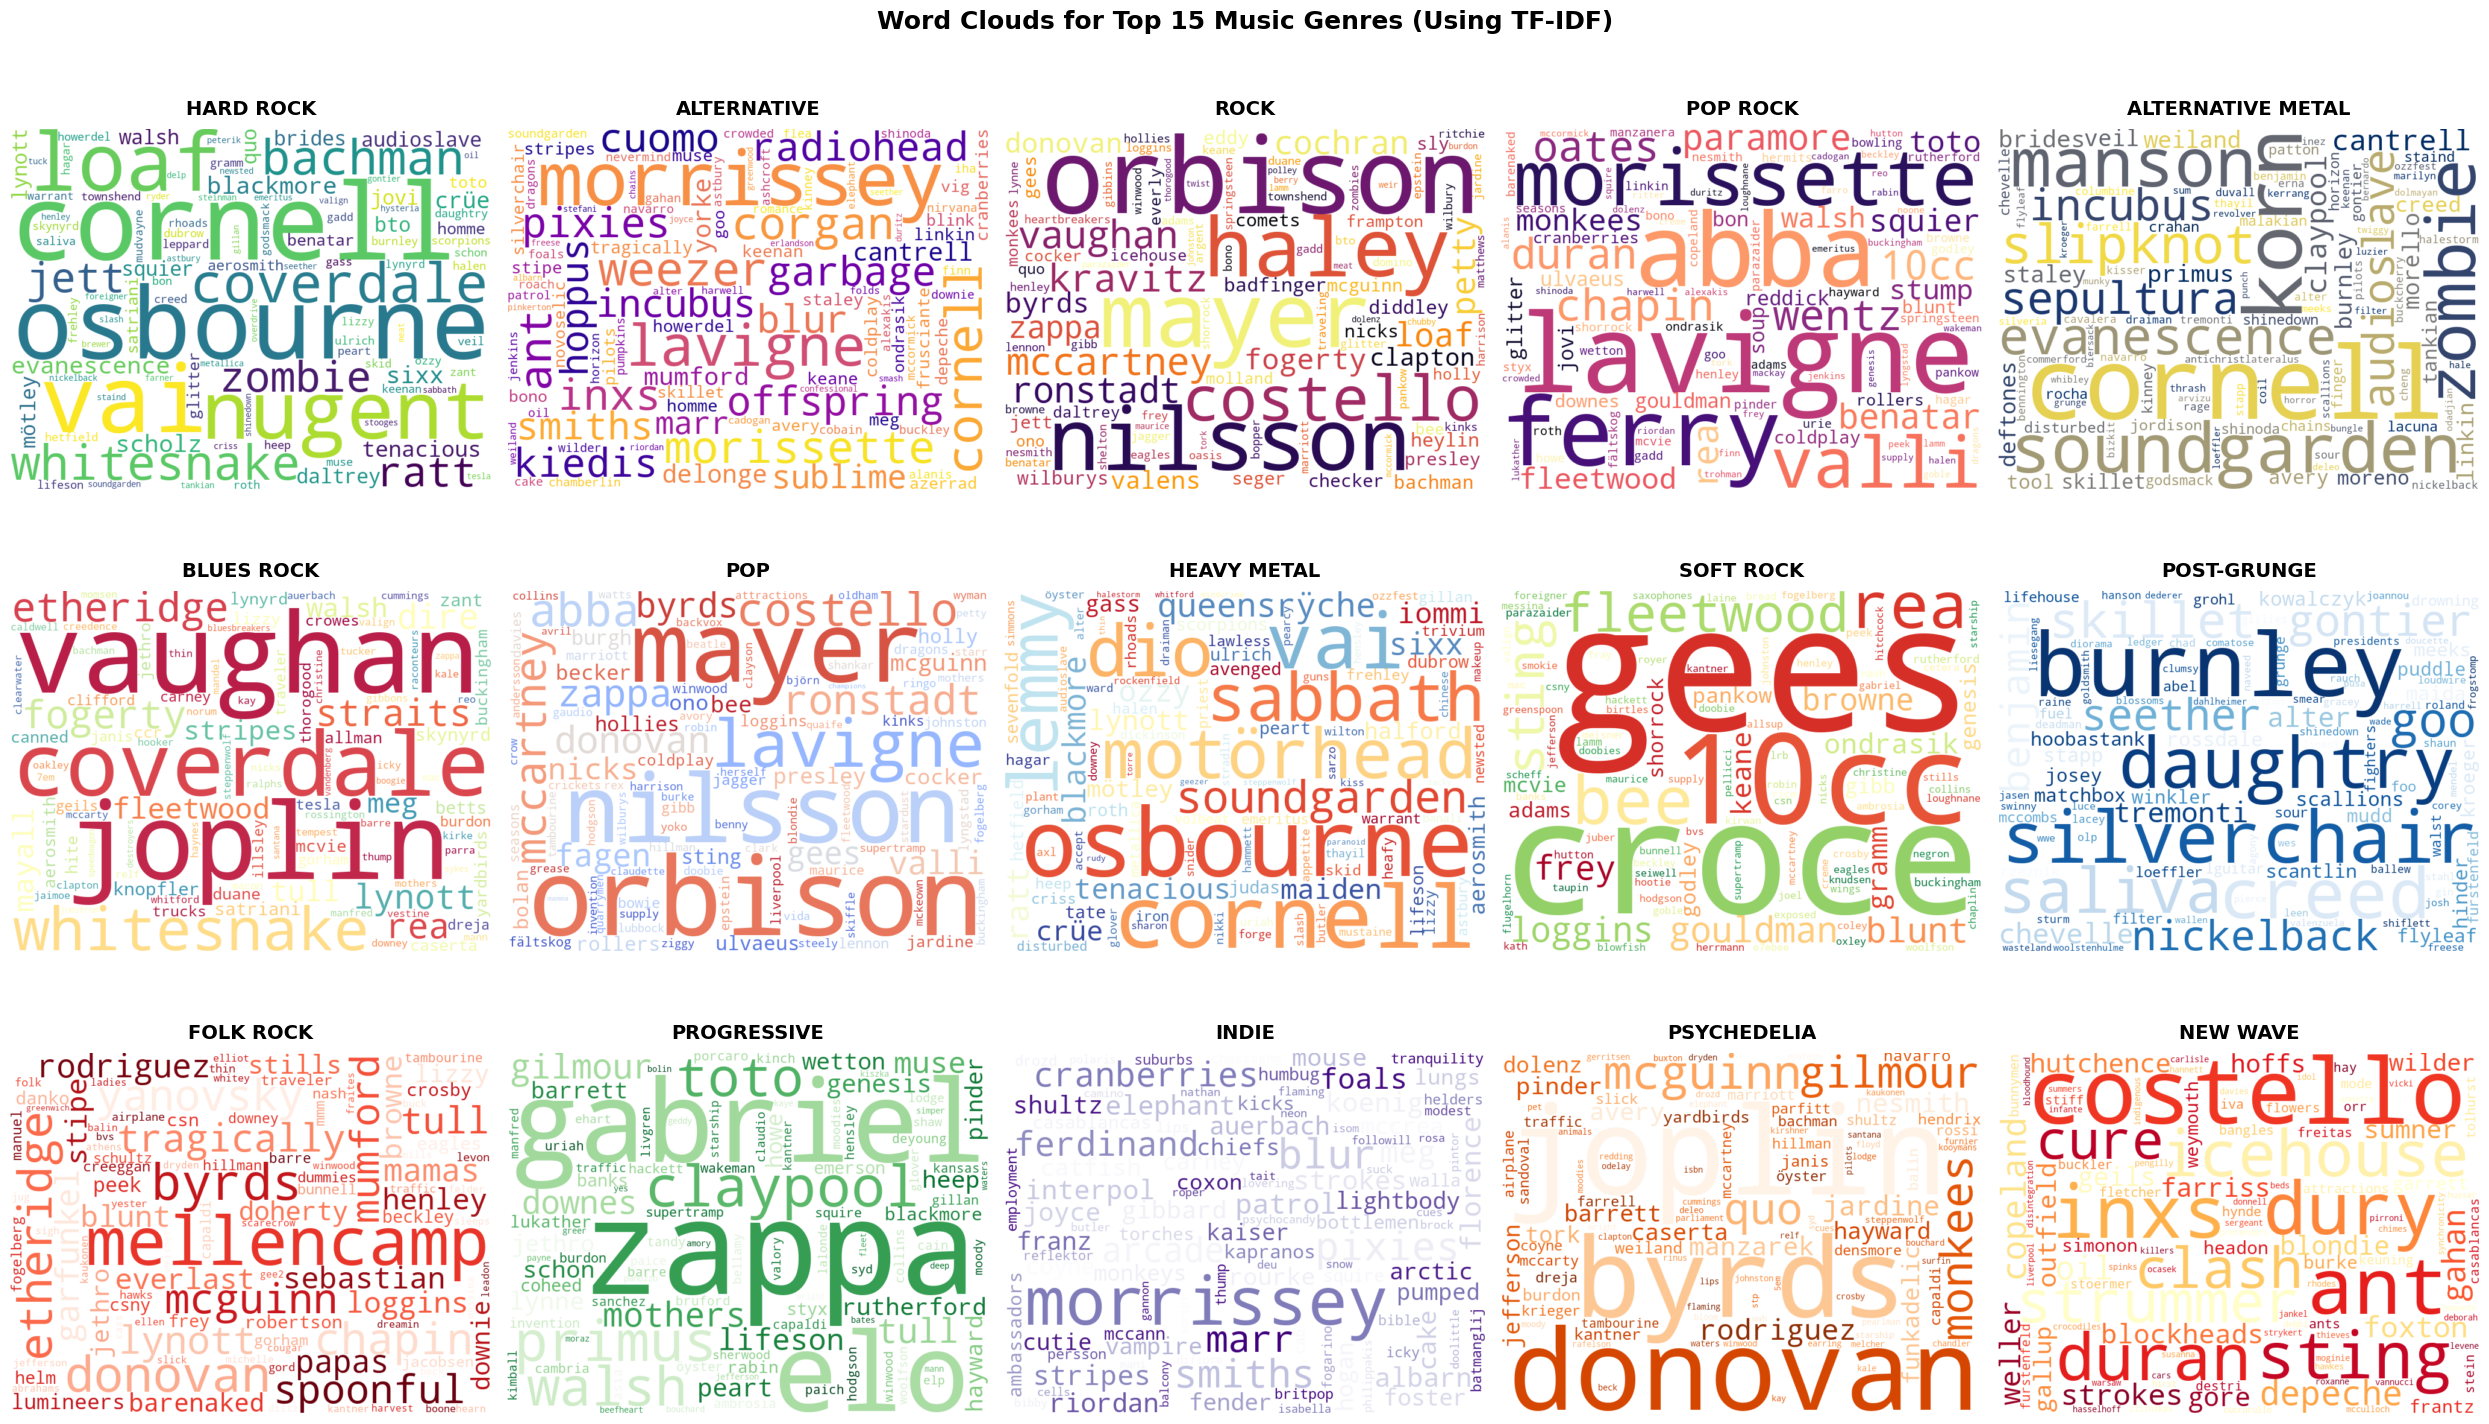

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()

# Color schemes for variety
color_schemes = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
    "cividis",
    "Spectral",
    "coolwarm",
    "RdYlBu",
    "RdYlGn",
    "Blues",
    "Reds",
    "Greens",
    "Purples",
    "Oranges",
    "YlOrRd",
]

for idx, genre in enumerate(tf_idf_top_15_genre.keys()):
    # Create WordCloud object
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color="white",
        colormap=color_schemes[idx],
        max_words=100,
        collocations=False,
        relative_scaling=0.5,
        min_font_size=10,
    ).generate_from_frequencies(tf_idf_top_15_genre[genre])
    # Display the wordcloud
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(f"{genre.upper()}", fontsize=14, fontweight="bold", pad=10)
    axes[idx].axis("off")

plt.suptitle(
    "Word Clouds for Top 15 Music Genres (Using TF-IDF)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

#### **Louvain Community TF-IDF Visualization using wordclouds**

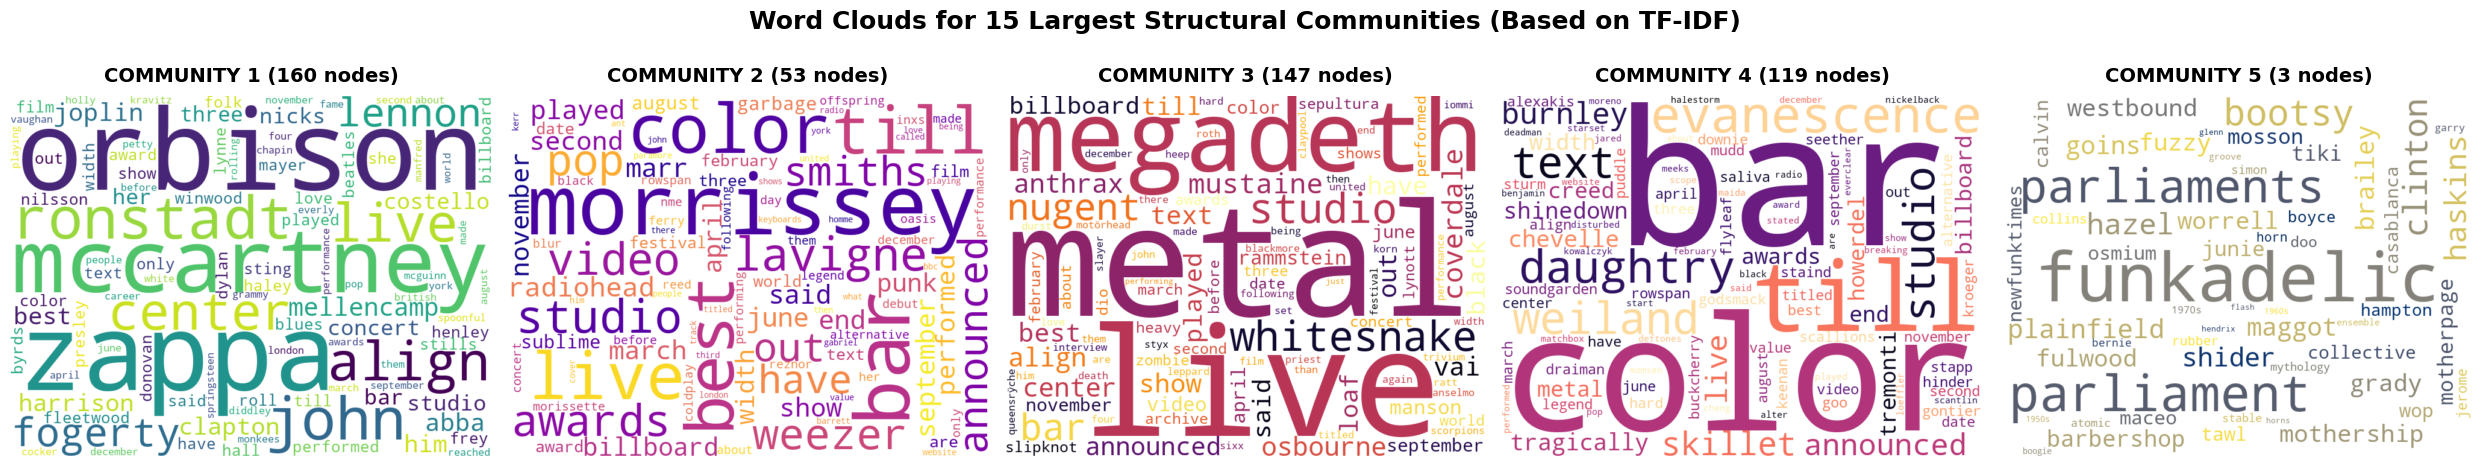

In [34]:
fig, axes = plt.subplots(1, len(louvain_communities), figsize=(len(louvain_communities)*5, 5))

color_schemes = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
    "cividis",
    "Spectral",
    "coolwarm",
    "RdYlBu",
    "RdYlGn",
    "Blues",
    "Reds",
    "Greens",
    "Purples",
    "Oranges",
    "YlOrRd",
]

for idx in range(len(louvain_communities)):
    community_label = f"Community_{idx + 1}"
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color="white",
        colormap=color_schemes[idx],
        max_words=100,
        collocations=False,
        relative_scaling=0.5,
        min_font_size=10,
    ).generate_from_frequencies(tf_idf_louvain_communities[community_label])

    # Display
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(
        f"COMMUNITY {idx + 1} ({len(louvain_communities[idx])} nodes)",
        fontsize=14,
        fontweight="bold",
        pad=10,
    )
    axes[idx].axis("off")

plt.suptitle(
    "Word Clouds for 15 Largest Structural Communities (Based on TF-IDF)",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

### **Exercise) Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.**

#### **Key Observations from the Confusion Matrix**

The confusion matrix reveals that **structural communities don't align cleanly with genre labels** - this suggests the network structure captures something beyond just musical style:

- **1st Community (160 nodes)**: Heavily dominated by rock (85) with significant pop rock (37), showing strong genre coherence
- **2nd Community (147 nodes)**: Extremely alternative-focused (84 out of 126 total alternative artists), indicating this community captures the alternative scene specifically
- **3rd Community (119 nodes)**: Primarily focusing on hard rock (68) artists, suggesting a heavier sound profile.
- **4th Community (53 nodes)**: The most genre-diverse, with almost an even split across 3 out of 5 most common categories. This community could be some sort of bridge between communities or connecting different subgenres.
- **5th Community (3 nodes)**: A completely isolated section of rock band/artists, who have been self-contained from the rest of the ecosystem.

Essentially it represents the entire Parliament-Funkadelic (aka. P-Funk) American music collective of musicians. universe captured as its own community. Despite having only 3 nodes, the network algorithm recognized this as structurally distinct, which reveals something profound about how this group operated.

#### Comparing Word Clouds: Communities vs Genres

**Artist Names vs Musical Descriptors**
- **Genre word clouds**: Dominated by **artist names** (Orbison, Morrissey, Lavigne, etc.)
- **Community word clouds**: There is more **thematic/contextual terms** plus artist names

This could suggest that communities form around:
- Shared influences and collaborations, where we have artist names such as McCartney, Oribson and Zappa dominating the 1st community's word cloud.
- **Record labels and scenes** (Community 5's "Westbound", "Parliament-Funkadelic" collective)
- **Era and movement connections** rather than pure genre classification

##### The Alternative Paradox
Community 1 captures 84 alternative artists but its word cloud shows classic rock icons (Orbison, Zappa, Lennon). This suggests:
- Alternative artists in this community may share **influences from classic rock pioneers**
- The network structure captures **musical lineage** that genre labels miss
- These alternative artists might cover or collaborate with classic rock artists

##### Community 5's Unique Identity
With only 3 nodes but extremely specific terminology (Parliament, Funkadelic, Bootsy), this represents a **tight-knit musical collective** - George Clinton's P-Funk empire. The network algorithm identified this as structurally distinct despite small size, showing it captures **actual collaboration patterns** rather than just genre similarity.

##### Genre Blending in Communities
Community 3's even distribution across genres (68 hard rock, 31 alternative, 31 pop rock) with terms like "megadeth", "whitesnake" alongside "metal", "studio", "live" suggests this community represents:
- **Crossover artists** who blend genres
- **Festival circuit bands** that play together despite different genre labels
- The **commercial/mainstream metal** scene that influenced multiple genres

#### Conclusion

The structural communities appear to capture social and professional networks (who worked together, shared musicians/labels and influenced each other). The word clouds reveal that communities preserve historical context and relationships that transcend simple genre boundaries, explaining why a community of "alternative" artists would be dominated by classic rock terminology - they're connected through influence networks rather than sound similarity alone.